In [ ]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://downloads.apache.org/spark/spark-3.0.1/spark-3.0.1-bin-hadoop2.7.tgz   
!tar -xvf spark-3.0.1-bin-hadoop2.7.tgz   
!pip install -q findspark

In [ ]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.0.1-bin-hadoop2.7"

import findspark
findspark.init()


In [ ]:
from pyspark import SparkConf,SparkContext
from pyspark.streaming import StreamingContext
from pyspark.sql import Row,SQLContext
import sys
import requests
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
import json
from pyspark.sql.functions import col
from pyspark.sql.functions import split, explode, explode_outer
conf = SparkConf().setAppName("LOL games")
sc = pyspark.SparkContext(conf=conf)




In [ ]:
from google.colab import files
uploaded = files.upload()

Saving games1000.json to games1000.json


In [ ]:
def get_stats_pick(line):
  line=json.loads(line)
  champ_names=[0]*10
  for i in range(10):
    champ_names[i]=(line["participants"][i]["championId"],1)   
  return champ_names
lines = sc.textFile("games1000.json")
total=len(lines.collect())
champion_names=lines.flatMap(lambda line:get_stats_pick(line))  
champion_names=champion_names.reduceByKey(lambda a,b:a+b)       
champion_picks=champion_names.map(lambda champ_picks:(champ_picks[0],champ_picks[1]/total))
#champion_names.collect()
champion_pick=champion_picks.collect()
champion_pick

In [ ]:
def get_stats_ban(line):
  line=json.loads(line)
  champ_names=[0]*10
  index=0
  for i in range(2):
    for j in range(5):
      champ_names[index]=(line["teams"][i]["bans"][j]["championId"],1)
      index+=1   
  return champ_names
champion_names=lines.flatMap(lambda line:get_stats_ban(line))  
#print(champion_names.collect())
champion_names=champion_names.reduceByKey(lambda a,b:a+b)       
champion_bans=champion_names.map(lambda champ_bans:(champ_bans[0],champ_bans[1]/total))
#champion_names.collect()
champ_ban=champion_bans.collect()

In [ ]:
def get_stats_win(line):
  line=json.loads(line)
  champ_names=[0]*10
  for i in range(10):
    if line["participants"][i]["stats"]["win"]==True:
      champ_names[i]=(line["participants"][i]["championId"],(1,0))
    else:
      champ_names[i]=(line["participants"][i]["championId"],(0,1))       
  return champ_names
champion_names=lines.flatMap(lambda line:get_stats_win(line))  # ((a,b),(c,d))
#print(champion_names.collect())
champion_names=champion_names.reduceByKey(lambda t1,t2:(t1[0]+t2[0],t1[1]+t2[1]))       
champion_wins=champion_names.map(lambda champ_wins:(champ_wins[0],champ_wins[1][0]/(champ_wins[1][0]+champ_wins[1][1])))
#champion_names.collect()
champ_win=champion_wins.collect()

In [ ]:
import itertools

In [ ]:
def get_stats_synergies(line): 
  line=json.loads(line)
  losser_champ_keys_vals=[]
  winner_champ_keys_vals=[]
  winner_champ_names=[0]*5
  losser_champ_names=[0]*5
  if line["teams"][0]["win"]=="Win" :
    for i in range(5):
      winner_champ_names[i]=line["participants"][i]["championId"]
      losser_champ_names[i]=line["participants"][i+5]["championId"]
  else:
    for i in range(5):
      winner_champ_names[i]=line["participants"][i+5]["championId"]
      losser_champ_names[i]=line["participants"][i]["championId"]

  winner_champ_keys=list(itertools.combinations(winner_champ_names, 2))
  winner_champ_keys = [tuple(sorted(i)) for i in winner_champ_keys]
  for t in winner_champ_keys:
    winner_champ_keys_vals.append((t,(1,0)))
  losser_champ_keys=list(itertools.combinations(losser_champ_names, 2))
  losser_champ_keys = [tuple(sorted(i)) for i in losser_champ_keys]
  for t in losser_champ_keys:
    losser_champ_keys_vals.append((t,(0,1)))
  champ_names=winner_champ_keys_vals+losser_champ_keys_vals
  return champ_names
champion_names=lines.flatMap(lambda line:get_stats_synergies(line))
#print(champion_names.collect())
champion_names=champion_names.reduceByKey(lambda t1,t2:(t1[0]+t2[0],t1[1]+t2[1]))       
champion_wins_synergies=champion_names.map(lambda champ_wins:(champ_wins[0],champ_wins[1][0]/(champ_wins[1][0]+champ_wins[1][1])))
#champion_names.collect()
champ_win_synergy=champion_wins_synergies.collect()
champ_win_synergy

In [ ]:
def get_stats_item_winrate(line):
  line=json.loads(line)
  winner_items_names=['0']*30
  losser_items_names=['0']*30
  if line["teams"][0]["win"]=="Win" :
    index=0
    for i in range(5):
        for j in range(0,6):
          try:
            if line["participants"][i]["stats"]["item"+str(j)]["into"]==[]:
              winner_items_names[index]=(line["participants"][i]["stats"]["item"+str(j)]["name"],(1,0))
            else:
              winner_items_names[index]=("No item",(1,0))
          except:
            winner_items_names[index]=("No item",(1,0))
            pass
          try:
            if line["participants"][i+5]["stats"]["item"+str(j)]["into"]==[]:
              losser_items_names[index]=(line["participants"][i+5]["stats"]["item"+str(j)]["name"],(0,1))
            else:
              losser_items_names[index]=("No item",(0,1))
          except:
            losser_items_names[index]=("No item",(1,0))
            pass
          index+=1
  else:
    index=0
    for i in range(5):
        for j in range(0,6):
          try:
            if line["participants"][i+5]["stats"]["item"+str(j)]["into"]==[]:
              winner_items_names[index]=(line["participants"][i+5]["stats"]["item"+str(j)]["name"],(1,0))
            else:
              winner_items_names[index]=("No item",(1,0))
          except:
            winner_items_names[index]=("No item",(1,0))
            pass
          try:
            if line["participants"][i]["stats"]["item"+str(j)]["into"]==[]:
              losser_items_names[index]=(line["participants"][i]["stats"]["item"+str(j)]["name"],(0,1))
            else:
              losser_items_names[index]=("No item",(0,1))
          except:
            losser_items_names[index]=("No item",(1,0))
            pass
          index+=1
  item_names=winner_items_names+losser_items_names
  return item_names
champion_names=lines.flatMap(lambda line:get_stats_item_winrate(line))
#print(champion_names.collect())
champion_names=champion_names.reduceByKey(lambda t1,t2:(t1[0]+t2[0],t1[1]+t2[1]))       
item_wins=champion_names.map(lambda champ_wins:(champ_wins[0],champ_wins[1][0]/(champ_wins[1][0]+champ_wins[1][1])))
#champion_names.collect()
item_win=item_wins.collect()
item_win

In [ ]:
def get_stats_item_pickrate(line):
  line=json.loads(line)
  winner_items_names=['0']*30
  losser_items_names=['0']*30
  if line["teams"][0]["win"]=="Win" :
    index=0
    for i in range(5):
        for j in range(0,6):
          try:
            if line["participants"][i]["stats"]["item"+str(j)]["into"]==[]:
              winner_items_names[index]=(line["participants"][i]["stats"]["item"+str(j)]["name"],(1,0))
            else:
              winner_items_names[index]=("No item",(1,0))
          except:
            winner_items_names[index]=("No item",(1,0))
            pass
          try:
            if line["participants"][i+5]["stats"]["item"+str(j)]["into"]==[]:
              losser_items_names[index]=(line["participants"][i+5]["stats"]["item"+str(j)]["name"],(0,1))
            else:
              losser_items_names[index]=("No item",(0,1))
          except:
            losser_items_names[index]=("No item",(1,0))
            pass
          index+=1
  else:
    index=0
    for i in range(5):
        for j in range(0,6):
          try:
            if line["participants"][i+5]["stats"]["item"+str(j)]["into"]==[]:
              winner_items_names[index]=(line["participants"][i+5]["stats"]["item"+str(j)]["name"],(1,0))
            else:
              winner_items_names[index]=("No item",(1,0))
          except:
            winner_items_names[index]=("No item",(1,0))
            pass
          try:
            if line["participants"][i]["stats"]["item"+str(j)]["into"]==[]:
              losser_items_names[index]=(line["participants"][i]["stats"]["item"+str(j)]["name"],(0,1))
            else:
              losser_items_names[index]=("No item",(0,1))
          except:
            losser_items_names[index]=("No item",(1,0))
            pass
          index+=1
  item_names=winner_items_names+losser_items_names
  return item_names
number_of_players=10
total_items=total * number_of_players
champion_names=lines.flatMap(lambda line:get_stats_item_pickrate(line))
#print(champion_names.collect())
champion_names=champion_names.reduceByKey(lambda t1,t2:(t1[0]+t2[0],t1[1]+t2[1]))       
item_picks=champion_names.map(lambda champ_wins:(champ_wins[0],(champ_wins[1][0]+champ_wins[1][1])/total_items))
#champion_names.collect()
item_pick_rate=item_picks.collect()
item_pick_rate

In [ ]:
def get_stats_item_synergies_champ(line):
  line=json.loads(line)
  winner_item_champ_pairs=['0']*30
  losser_item_champ_pairs=['0']*30
  winner_items_names=['0']*30
  losser_items_names=['0']*30
  winner_champs=['0']*5
  losser_champs=['0']*5
  if line["teams"][0]["win"]=="Win" :
    index=0
    for i in range(5):
        for j in range(0,6):
          try:
            if line["participants"][i]["stats"]["item"+str(j)]["into"]==[]:
              winner_items_names[index]=line["participants"][i]["stats"]["item"+str(j)]["name"]
            else:
              winner_items_names[index]="No item"
            winner_champs[i]=line["participants"][i]["championId"]
          except:
            winner_items_names[index]="No item"
            pass
          finally:
            winner_item_champ_pairs[index]=((winner_champs[i],winner_items_names[index]),(1,0))
          try:
            if line["participants"][i+5]["stats"]["item"+str(j)]["into"]==[]:
              losser_items_names[index]=line["participants"][i+5]["stats"]["item"+str(j)]["name"]
            else:
              losser_items_names[index]="No item"
            losser_champs[i]=line["participants"][i+5]["championId"]
          except:
            losser_items_names[index]="No item"
            pass
          finally:
            losser_item_champ_pairs[index]=((losser_champs[i],losser_items_names[index]),(0,1))
          index+=1
  else:
    index=0
    for i in range(5):
        for j in range(0,6):
          try:
            if line["participants"][i+5]["stats"]["item"+str(j)]["into"]==[]:
              winner_items_names[index]=line["participants"][i+5]["stats"]["item"+str(j)]["name"]
            else:
              winner_items_names[index]="No item"
            winner_champs[i]=line["participants"][i+5]["championId"]
          except:
            winner_items_names[index]="No item"
            pass
          finally:
            winner_item_champ_pairs[index]=((winner_champs[i],winner_items_names[index]),(1,0))
          try:
            if line["participants"][i]["stats"]["item"+str(j)]["into"]==[]:
              losser_items_names[index]=line["participants"][i]["stats"]["item"+str(j)]["name"]
            else:
              losser_items_names[index]="No item"
            losser_champs[i]=line["participants"][i]["championId"]
          except:
            losser_items_names[index]="No item"
            pass
          finally:
            losser_item_champ_pairs[index]=((losser_champs[i],losser_items_names[index]),(0,1))  
          index+=1
  item_champ_pairs=winner_item_champ_pairs+losser_item_champ_pairs
  return item_champ_pairs
number_of_players=10
total_items=total * number_of_players
champion_names=lines.flatMap(lambda line:get_stats_item_synergies_champ(line))
#print(champion_names.collect())
champion_names=champion_names.reduceByKey(lambda t1,t2:(t1[0]+t2[0],t1[1]+t2[1]))       
item_champ_synergy=champion_names.map(lambda champ_wins:(champ_wins[0],champ_wins[1][0]/(champ_wins[1][0]+champ_wins[1][1])))
#champion_names.collect()
item_champ_synergyy=item_champ_synergy.collect()
item_champ_synergyy

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving champion_class.json to champion_class.json


In [ ]:
f = open('champion_class.json',)
champ_class_dictionary={}
data = json.load(f) 
for champ in data:
  champ_name=champ['championId']
  champ_class=champ['tags'][0]
  champ_class_dictionary[champ_name]=champ_class
champ_class_dictionary

In [ ]:
def get_champion_class(champ_name):
  return champ_class_dictionary[champ_name]
def get_stats_item_synergies_class(line):
  line=json.loads(line)
  winner_item_champ_pairs=['0']*30
  losser_item_champ_pairs=['0']*30
  winner_items_names=['0']*30
  losser_items_names=['0']*30
  winner_champs=['0']*5
  losser_champs=['0']*5
  if line["teams"][0]["win"]=="Win" :
    index=0
    for i in range(5):
        for j in range(0,6):
          try:
            if line["participants"][i]["stats"]["item"+str(j)]["into"]==[]:
              winner_items_names[index]=line["participants"][i]["stats"]["item"+str(j)]["name"]
            else:
              winner_items_names[index]="No item"
            winner_champs[i]=get_champion_class(line["participants"][i]["championId"])
          except:
            winner_items_names[index]="No item"
            pass
          finally:
            winner_item_champ_pairs[index]=((winner_champs[i],winner_items_names[index]),(1,0))
          try:
            if line["participants"][i+5]["stats"]["item"+str(j)]["into"]==[]:
              losser_items_names[index]=line["participants"][i+5]["stats"]["item"+str(j)]["name"]
            else:
              losser_items_names[index]="No item"
            losser_champs[i]=get_champion_class(line["participants"][i+5]["championId"])
          except:
            losser_items_names[index]="No item"
            pass
          finally:
            losser_item_champ_pairs[index]=((losser_champs[i],losser_items_names[index]),(0,1))
          index+=1
  else:
    index=0
    for i in range(5):
        for j in range(0,6):
          try:
            if line["participants"][i+5]["stats"]["item"+str(j)]["into"]==[]:
              winner_items_names[index]=line["participants"][i+5]["stats"]["item"+str(j)]["name"]
            else:
              winner_items_names[index]="No item"
            winner_champs[i]=get_champion_class(line["participants"][i+5]["championId"])
          except:
            winner_items_names[index]="No item"
            pass
          finally:
            winner_item_champ_pairs[index]=((winner_champs[i],winner_items_names[index]),(1,0))
          try:
            if line["participants"][i]["stats"]["item"+str(j)]["into"]==[]:
              losser_items_names[index]=line["participants"][i]["stats"]["item"+str(j)]["name"]
            else:
              losser_items_names[index]="No item"
            losser_champs[i]=get_champion_class(line["participants"][i]["championId"])
          except:
            losser_items_names[index]="No item"
            pass
          finally:
            losser_item_champ_pairs[index]=((losser_champs[i],losser_items_names[index]),(0,1))  
          index+=1
  item_champ_pairs=winner_item_champ_pairs+losser_item_champ_pairs
  return item_champ_pairs
number_of_players=10
total_items=total * number_of_players
champion_names=lines.flatMap(lambda line:get_stats_item_synergies_class(line))
#print(champion_names.collect())
champion_names=champion_names.reduceByKey(lambda t1,t2:(t1[0]+t2[0],t1[1]+t2[1]))       
item_class_synergy=champion_names.map(lambda champ_wins:(champ_wins[0],champ_wins[1][0]/(champ_wins[1][0]+champ_wins[1][1])))
#champion_names.collect()
item_class_synergyy=item_class_synergy=item_class_synergy.collect()
item_class_synergyy

In [ ]:
def get_stats_item_suggestion(line):
  line=json.loads(line)
  winner_champ_all_items=[]
  losser_champ_all_items=[]
  winner_item_champ_pairs=['0']*30
  losser_item_champ_pairs=['0']*30
  winner_items_names=['0']*30
  losser_items_names=['0']*30
  winner_champs=['0']*5
  losser_champs=['0']*5
  if line["teams"][0]["win"]=="Win" :
    index=0
    for i in range(5):
        for j in range(0,6):
          try:
            if line["participants"][i]["stats"]["item"+str(j)]["into"]==[]:
              winner_items_names[index]=line["participants"][i]["stats"]["item"+str(j)]["name"]
            else:
              winner_items_names[index]="No item"
            winner_champs[i]=line["participants"][i]["championId"]
          except:
            winner_items_names[index]="No item"
            pass
          try:
            if line["participants"][i+5]["stats"]["item"+str(j)]["into"]==[]:
              losser_items_names[index]=line["participants"][i+5]["stats"]["item"+str(j)]["name"]
            else:
              losser_items_names[index]="No item"
            losser_champs[i]=line["participants"][i+5]["championId"]
          except:
            losser_items_names[index]="No item"
            pass
          index+=1
    for i in range(5):
      z=i*6
      # winner_champ_all_items.append(((winner_champs[i],tuple(winner_items_names[0+z:6+z])),(1,0)))
      # losser_champ_all_items.append(((losser_champs[i],tuple(losser_items_names[0+z:6+z])),(0,1)))  
      winner_champ_all_items.append(((winner_champs[i],tuple([tuple(sorted(i)) for i in [winner_items_names[0+z:6+z]]])),(1,0)))
      losser_champ_all_items.append(((winner_champs[i],tuple([tuple(sorted(i)) for i in [losser_items_names[0+z:6+z]]])),(0,1)))

  else:
    index=0
    for i in range(5):
        for j in range(0,6):
          try:
            if line["participants"][i+5]["stats"]["item"+str(j)]["into"]==[]:
              winner_items_names[index]=line["participants"][i+5]["stats"]["item"+str(j)]["name"]
            else:
              winner_items_names[index]="No item"
            winner_champs[i]=line["participants"][i+5]["championId"]
          except:
            winner_items_names[index]="No item"
            pass
          try:
            if line["participants"][i]["stats"]["item"+str(j)]["into"]==[]:
              losser_items_names[index]=line["participants"][i]["stats"]["item"+str(j)]["name"]
            else:
              losser_items_names[index]="No item"
            losser_champs[i]=line["participants"][i]["championId"]
          except:
            losser_items_names[index]="No item"
            pass  
          index+=1
    for i in range(5):
      z=i*6
      # winner_champ_all_items.append(((winner_champs[i],tuple(winner_items_names[0+z:6+z])),(1,0)))
      # losser_champ_all_items.append(((losser_champs[i],tuple(losser_items_names[0+z:6+z])),(0,1)))
      winner_champ_all_items.append(((winner_champs[i],tuple([tuple(sorted(i)) for i in [winner_items_names[0+z:6+z]]])),(1,0)))
      losser_champ_all_items.append(((winner_champs[i],tuple([tuple(sorted(i)) for i in [losser_items_names[0+z:6+z]]])),(0,1)))
  item_champ_suggestion=winner_champ_all_items+losser_champ_all_items
  return item_champ_suggestion
number_of_players=10
total_items=total * number_of_players
champion_names=lines.flatMap(lambda line:get_stats_item_suggestion(line))
#print(champion_names.collect())
champion_names=champion_names.reduceByKey(lambda t1,t2:(t1[0]+t2[0],t1[1]+t2[1]))       
item_champ_suggestions=champion_names.map(lambda champ_wins:(champ_wins[0],champ_wins[1][0]/(champ_wins[1][0]+champ_wins[1][1])))
#champion_names.collect()
item_champ_suggestionss=item_champ_suggestions.collect()
item_champ_suggestionss

In [ ]:
def get_stats_first_tower_win(line):
  line=json.loads(line)
  if line["teams"][0]["win"]=="Win" :
    if line["teams"][0]["firstTower"]==True:
      team=("Team_0",(1,0))
    else:
      team=("Team_0",(0,1))
  else:
    if line["teams"][1]["firstTower"]==True:
      team=("Team_1",(1,0))
    else:
      team=("Team_1",(0,1))      
  return [team]
champion_names=lines.flatMap(lambda line:get_stats_first_tower_win(line))  
#print(champion_names.collect())
champion_names=champion_names.reduceByKey(lambda t1,t2:(t1[0]+t2[0],t1[1]+t2[1]))       
first_tower_wins=champion_names.map(lambda champ_wins:(champ_wins[0],champ_wins[1][0]/(champ_wins[1][0]+champ_wins[1][1])))
#champion_names.collect()
first_tower_wins.collect()

[('Team_1', 0.748062015503876), ('Team_0', 0.7169421487603306)]

## Visualization Part

In [ ]:
# Champion Pick Rate
sorted_champ=champion_pick.sort(key=lambda x:x[1],reverse=True)
champs=[champ for (champ,pick) in champion_pick]
picks=[pick for (champ,pick) in champion_pick]
import matplotlib.pyplot as plt
fig = plt.figure()
fig.set_size_inches(125,5)
ax = fig.add_axes([0,0,1,1])
ax.set_ylabel('Pick rate')
ax.set_xlabel('Champion')
ax.bar(champs,picks)
plt.show()


In [ ]:
# Champion ban Rate
sorted_champ=champ_ban.sort(key=lambda x:x[1],reverse=True)
champs=[champ for (champ,ban) in champ_ban]
bans= [ban for (champ,ban) in champ_ban]
import matplotlib.pyplot as plt
fig = plt.figure()
fig.set_size_inches(125,5)
ax = fig.add_axes([0,0,1,1])
ax.set_ylabel('Ban rate')
ax.set_xlabel('Champion')
ax.bar(champs,bans)
plt.show()



In [ ]:
# Champion win Rate
sorted_champ=champ_win.sort(key=lambda x:x[1],reverse=True)
champs=[champ for (champ,win) in champ_win]
wins= [win for (champ,win) in champ_win]
import matplotlib.pyplot as plt
fig = plt.figure()
fig.set_size_inches(125,5)
ax = fig.add_axes([0,0,1,1])
ax.set_ylabel('Win rate')
ax.set_xlabel('Champion')
ax.bar(champs,wins)
plt.show()



In [ ]:
# champ_win_synergy
champ_win_synergy.sort(key=lambda x:x[1],reverse=True)
champ_pairs=[str(t) for (t,win) in champ_win_synergy]
pair_wins=[win for (t,win) in champ_win_synergy]
fig = plt.figure()
fig.set_size_inches(20,5)
ax = fig.add_axes([0,0,1,1])
ax.set_ylabel('combined Win rate')
ax.set_xlabel('Champion pair')
ax.bar(champ_pairs[:10],pair_wins[:10])
plt.show()




In [ ]:
# item_win_rate
item_win.sort(key=lambda x:x[1],reverse=True)
champ_pairs=[t for (t,win) in item_win]
pair_wins=[win for (t,win) in item_win]
fig = plt.figure()
fig.set_size_inches(200,5)
ax = fig.add_axes([0,0,1,1])
ax.set_ylabel(' Win rate')
ax.set_xlabel('item')
ax.bar(champ_pairs,pair_wins)
plt.show()

In [ ]:
item_pick_rate
# item_pick_rate
item_pick_rate.sort(key=lambda x:x[1],reverse=True)
champ_pairs=[t for (t,win) in item_pick_rate]
pair_wins=[win for (t,win) in item_pick_rate]
fig = plt.figure()
fig.set_size_inches(200,5)
ax = fig.add_axes([0,0,1,1])
ax.set_ylabel(' pick rate')
ax.set_xlabel('item')
ax.bar(champ_pairs[1:],pair_wins[1:])
plt.show()

In [ ]:
item_champ_synergyy
# champ_item_synergy
item_champ_synergyy.sort(key=lambda x:x[1],reverse=True)
champ_pairs=[str(t) for (t,win) in item_champ_synergyy]
pair_wins=[win for (t,win) in item_champ_synergyy]
fig = plt.figure()
fig.set_size_inches(30,5)
ax = fig.add_axes([0,0,1,1])
ax.set_ylabel('combined Win rate')
ax.set_xlabel('Champion item pair')
ax.bar(champ_pairs[:10],pair_wins[:10])
plt.show()




In [ ]:
# item_class_synergyy
item_class_synergyy.sort(key=lambda x:x[1],reverse=True)
champ_pairs=[str(t) for (t,win) in item_class_synergyy]
pair_wins=[win for (t,win) in item_class_synergyy]
fig = plt.figure()
fig.set_size_inches(25,5)
ax = fig.add_axes([0,0,1,1])
ax.set_ylabel('combined Win rate')
ax.set_xlabel('class item pair')
ax.bar(champ_pairs[:10],pair_wins[:10])
plt.show()

In [ ]:
# item_champ_suggestionss
item_champ_suggestionss.sort(key=lambda x:x[0][0],reverse=False)
item_champ_suggestionss

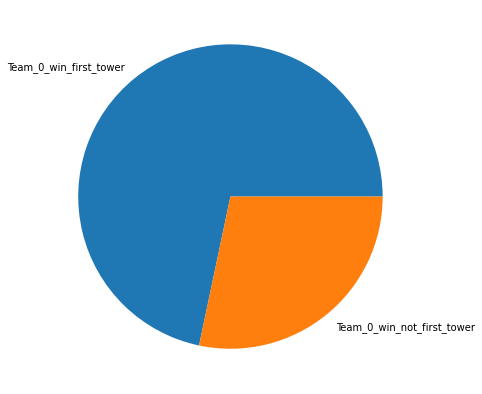

In [ ]:
Teams=["Team_0_win_first_tower","Team_0_win_not_first_tower"]
win_rate=[0.7169421487603306,1-0.7169421487603306]
fig = plt.figure(figsize =(7, 7)) 
plt.pie(win_rate, labels = Teams) 
plt.show()

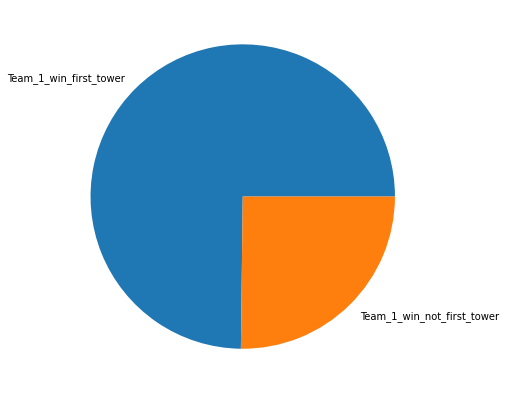

In [ ]:
Teams=["Team_1_win_first_tower","Team_1_win_not_first_tower"]
win_rate=[0.748062015503876,1-0.748062015503876]
fig = plt.figure(figsize =(7, 7)) 
plt.pie(win_rate, labels = Teams) 
plt.show()

In [ ]:
name=get_champion_class("Akali")
name

In [ ]:
t=["Sivir","Talon","Garen","Zed","Akali"]
c = list(itertools.combinations(t, 2))
print(c)
c = [tuple(sorted(i)) for i in c]
print(c)

In [ ]:
s=len(lines.collect())
s

In [ ]:
L1=((1,2),(1,0))
# L2=[(4,5,6)]
# L3=L1+L2
# L3
L1[1][0]

In [ ]:
import gzip
!unzip -u "/content/league-of-legends-patch-109.zip"

In [ ]:
!pip install bigjson

In [ ]:
from google.colab import files
uploaded = files.upload()

In [ ]:
import bigjson
import json

with open('games100.json', 'rb') as f:
  j = json.load(f)
  print(j)

In [ ]:
vals=get_stats(j)
print(vals)

In [ ]:
lis=[1,2,3,4]
lis[1:4]

In [ ]:
name=j["participants"][0]["stats"]["item"+str(0)]["name"]
name

In [ ]:
dic={"item1":4325}
i=1
dic["item"+str(i)]

In [ ]:
dic1={"tags":[1,2]}
dic2={"tags":[1]}
#print(dic2['tags'][0])
lst=[]
lst==[]